<a href="https://colab.research.google.com/github/thatajml/Student-Performance-Prediction/blob/dataset/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded successfully!

Dataset Shape: (2000, 17)
First 5 Rows:
   id first_name last_name                                  email  gender  \
0   1       Paul     Casey         paul.casey.1@gslingacademy.com    male   
1   2   Danielle  Sandoval  danielle.sandoval.2@gslingacademy.com  female   
2   3       Tina   Andrews       tina.andrews.3@gslingacademy.com  female   
3   4       Tara     Clark         tara.clark.4@gslingacademy.com  female   
4   5    Anthony    Campos     anthony.campos.5@gslingacademy.com    male   

   part_time_job  absence_days  extracurricular_activities  \
0          False             3                       False   
1          False             2                       False   
2          False             9                        True   
3          False             5                       False

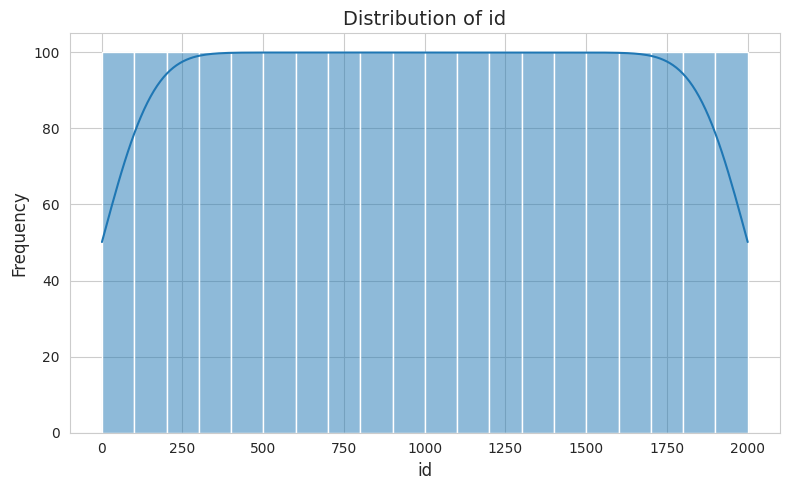

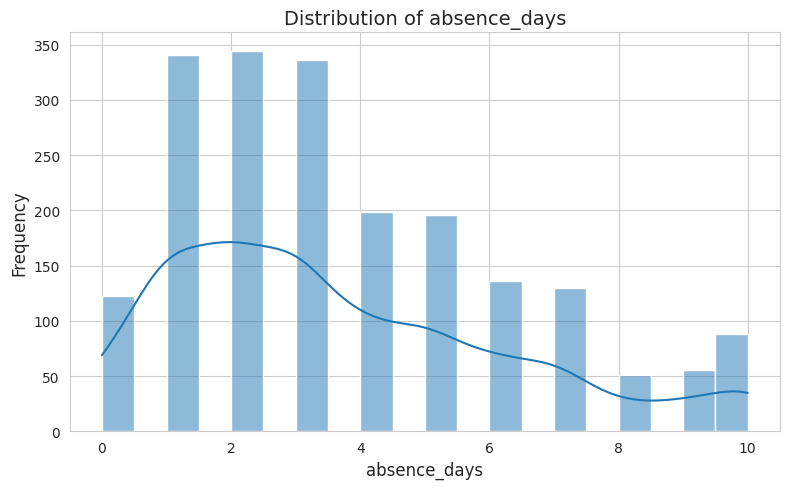

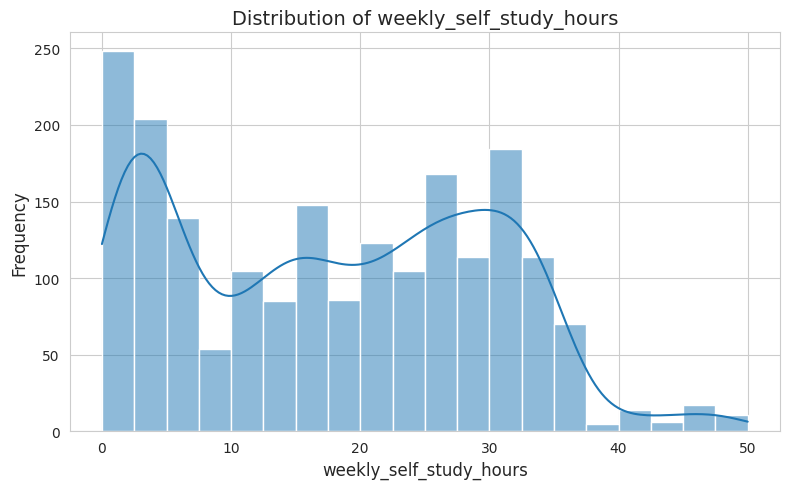

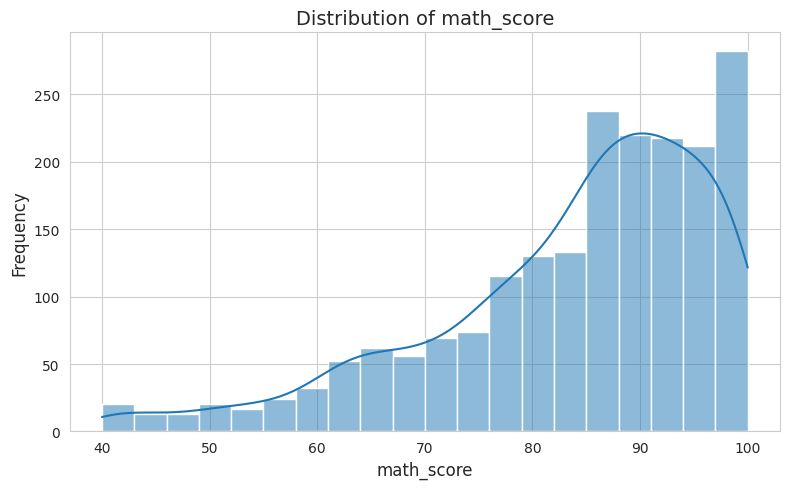

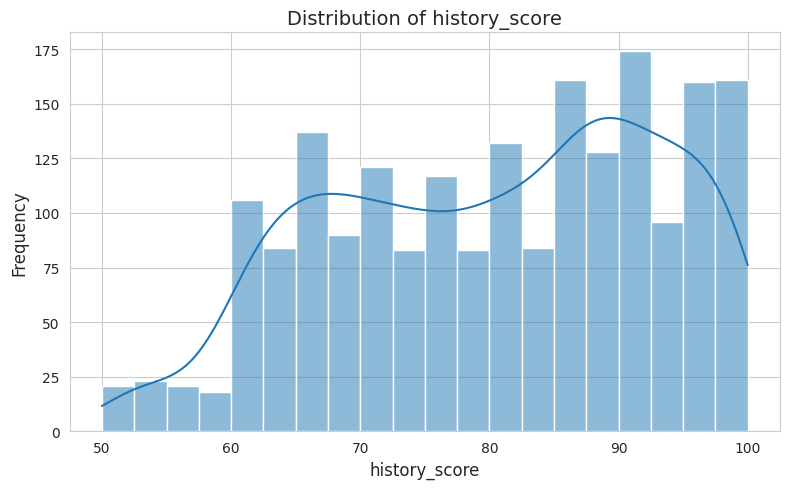

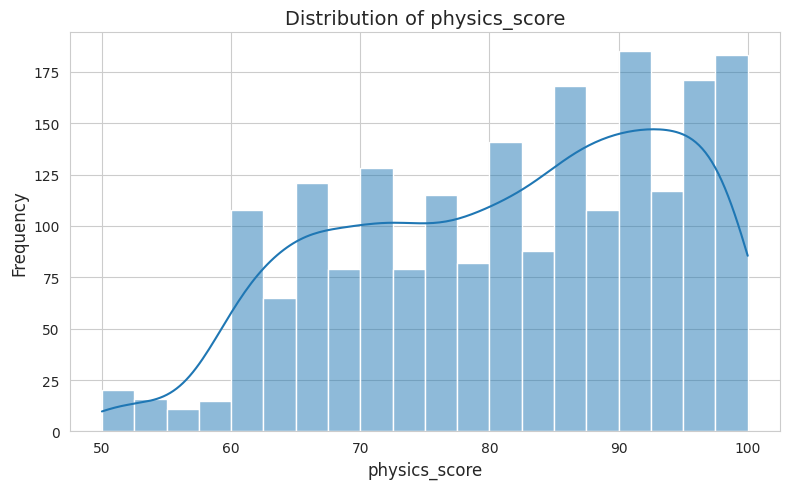

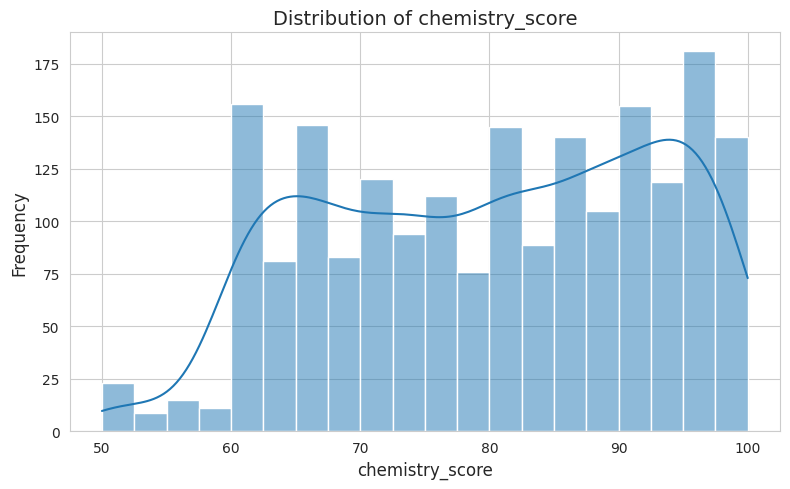

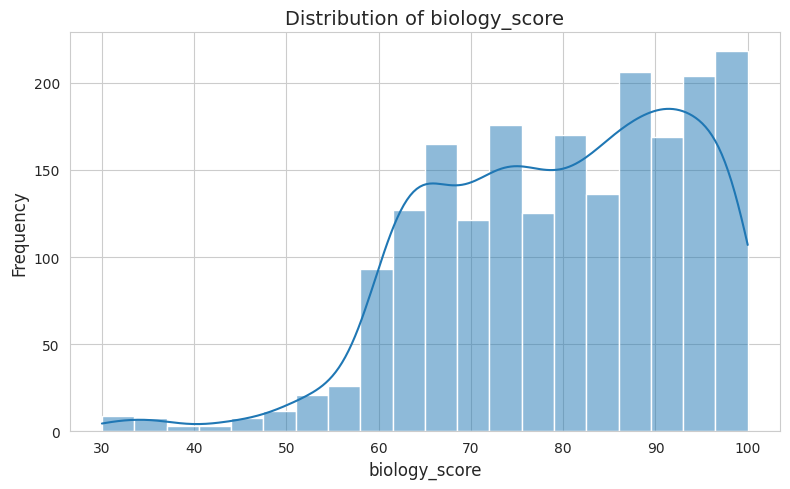

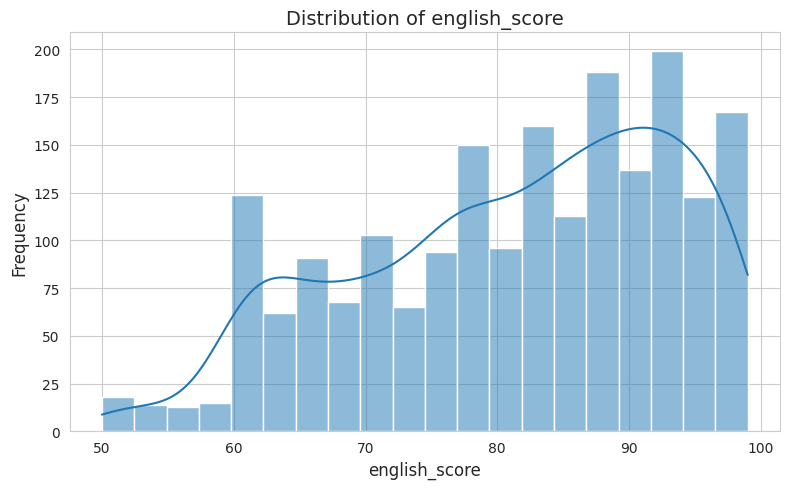

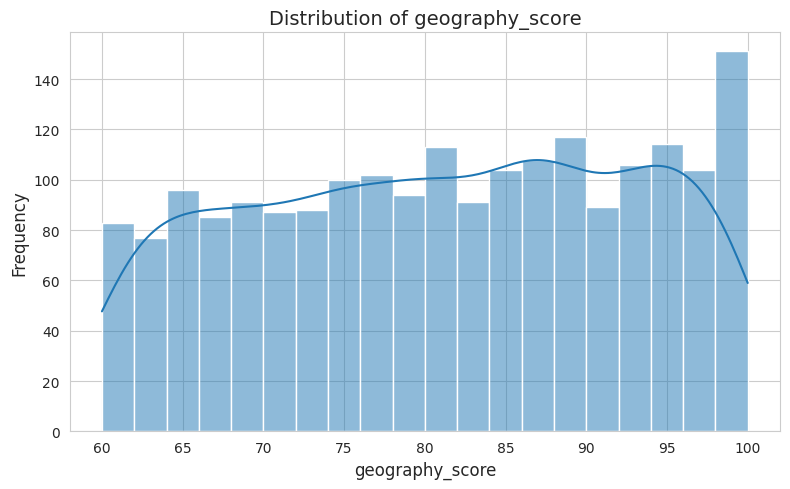

/tmp/ipython-input-2454638683.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, palette='viridis', order=df[col].value_counts().index)


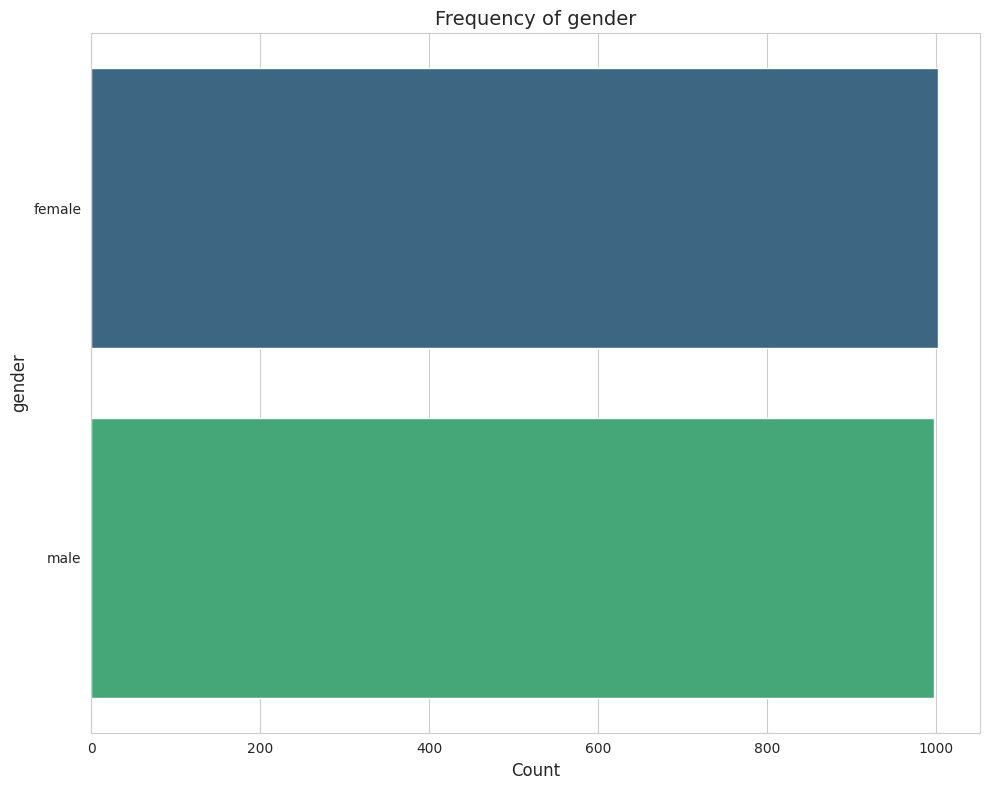

/tmp/ipython-input-2454638683.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=col, palette='viridis', order=df[col].value_counts().index)


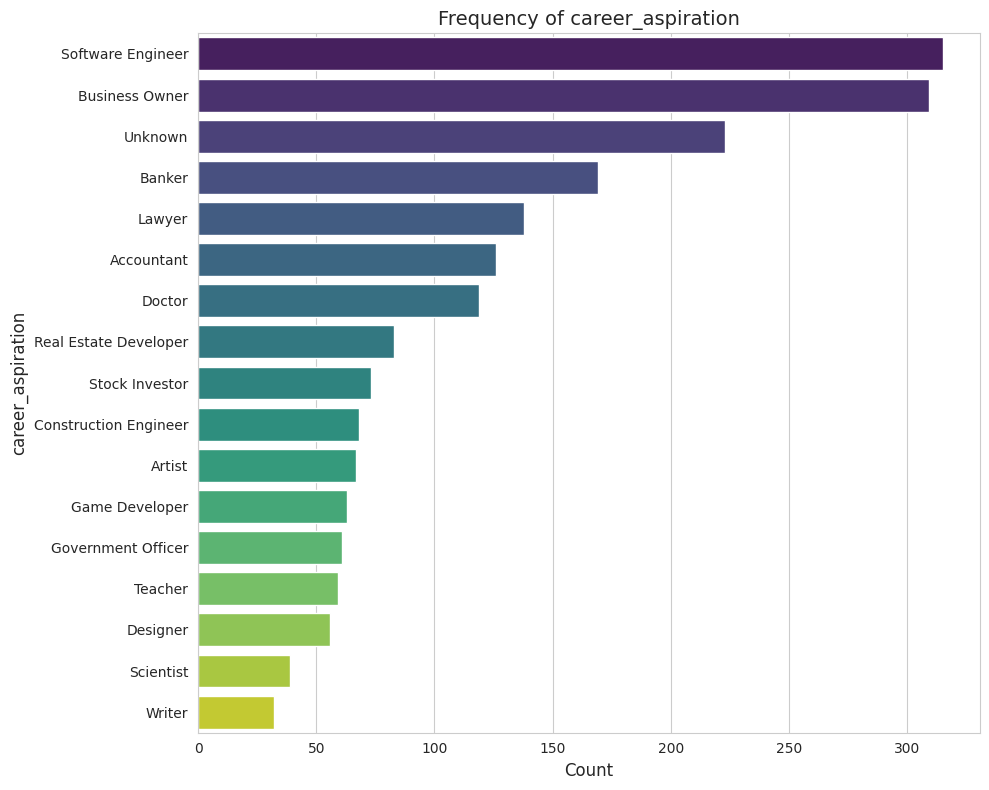

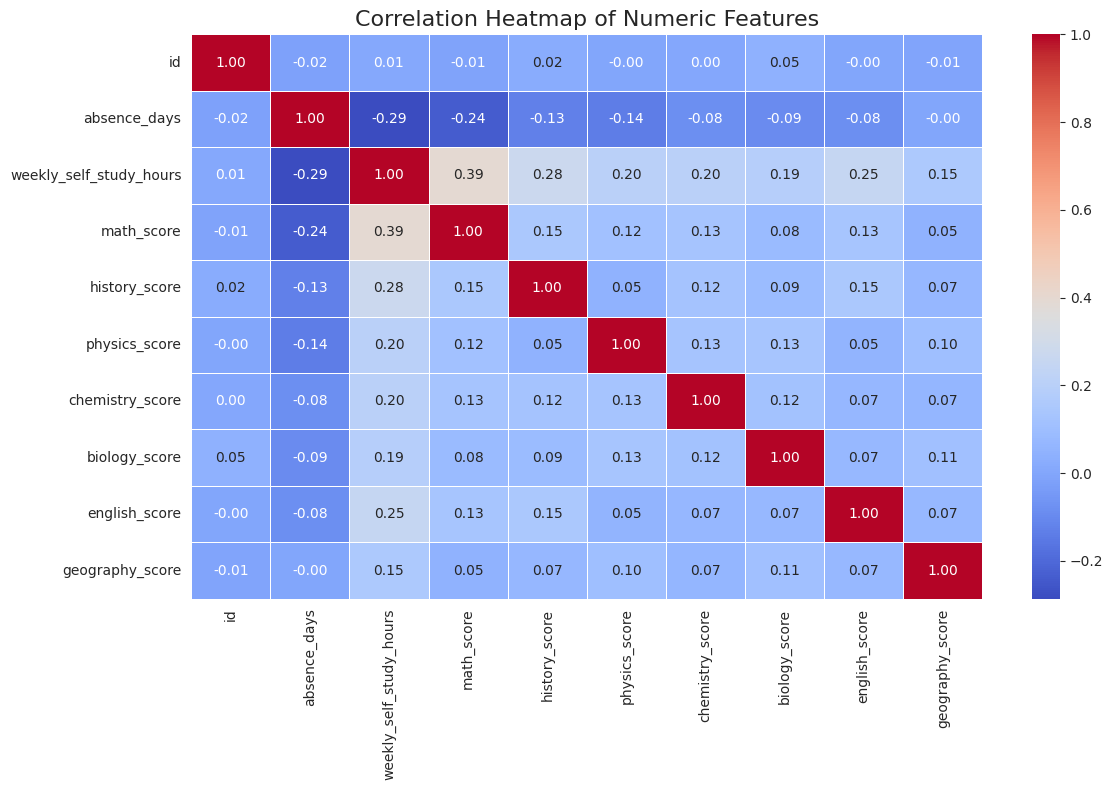


--- SCRIPT FINISHED ---


In [10]:
# ====================================================================
# STUDENT PERFORMANCE PREDICTION: DATA PREPROCESSING & EDA SCRIPT
# ====================================================================

# ---------------------------
# 1. IMPORT LIBRARIES
# ---------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from google.colab import drive

# ---------------------------
# 2. MOUNT DRIVE & LOAD DATA
# ---------------------------
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# --- IMPORTANT: Change this path to where your file is located ---
file_path = "/content/drive/My Drive/ML Miniproject Dataset/student-scores.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully!")
    print("\nDataset Shape:", df.shape)
    print("First 5 Rows:")
    print(df.head())
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {file_path}. Please check the file path and try again.")
    # Stop the script if the file isn't found
    exit()


# ---------------------------
# 3. PREPROCESSING PIPELINE
# ---------------------------
print("\nStarting data preprocessing...")

# Separate columns into numeric and categorical types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Apply the transformations
df_cleaned_np = preprocessor.fit_transform(df)

# Get new column names after one-hot encoding
# This is a bit complex but ensures the column names in the final DataFrame are correct
try:
    cat_encoded_cols = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols)
    all_cols = num_cols + list(cat_encoded_cols)
except AttributeError: # Handles older scikit-learn versions
    cat_encoded_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
    all_cols = num_cols + list(cat_encoded_cols)


# Create the cleaned DataFrame
df_cleaned = pd.DataFrame(df_cleaned_np, columns=all_cols, index=df.index)

print("✅ Preprocessing complete!")
print("Cleaned data shape:", df_cleaned.shape)


# ---------------------------
# 4. SAVE CLEANED DATA & SUMMARY
# ---------------------------
# --- IMPORTANT: Define the folder path on your Drive to save the outputs ---
output_folder_path = "/content/drive/My Drive/ML Miniproject Dataset/"

# Save cleaned data to a CSV file
cleaned_csv_path = "cleaned_student_scores.csv"
df_cleaned.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned dataset saved locally as '{cleaned_csv_path}'")

# Create and save EDA summary
summary = f"""
EDA Summary Report
------------------
Date: {pd.to_datetime('today').strftime('%Y-%m-%d')}

1.  **Dataset Shape**: {df.shape[0]} rows, {df.shape[1]} columns.
2.  **Preprocessing Steps**:
    * **Missing Numeric Values**: Imputed with column mean.
    * **Missing Categorical Values**: Imputed with column mode (most frequent).
    * **Numeric Scaling**: Standardized using StandardScaler (mean=0, std=1).
    * **Categorical Encoding**: Transformed using OneHotEncoder.
3.  **Output**:
    * Cleaned dataset shape: {df_cleaned.shape[0]} rows, {df_cleaned.shape[1]} columns.
    * Saved to 'cleaned_student_scores.csv'.
"""
summary_path = "EDA_Summary.txt"
with open(summary_path, "w") as f:
    f.write(summary)
print(f"✅ EDA summary saved locally as '{summary_path}'")

# Copy the saved files to Google Drive
!cp {cleaned_csv_path} "{output_folder_path}"
!cp {summary_path} "{output_folder_path}"
print(f"\n✅ All outputs successfully copied to your Google Drive folder!")


# ---------------------------
# 5. GENERATE VISUALIZATIONS (EDA)
# ---------------------------
print("\nGenerating visualizations...")
sns.set_style("whitegrid")

# --- Histograms for numeric data ---
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Countplots for MEANINGFUL categorical data ---
# 🧠 IMPORTANT: Exclude high-cardinality identifiers from plotting
cols_to_exclude = ['email', 'first_name', 'last_name']
cat_cols_to_plot = [col for col in cat_cols if col not in cols_to_exclude]

for col in cat_cols_to_plot:
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y=col, palette='viridis', order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}", fontsize=14)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(12, 8))
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

print("\n--- SCRIPT FINISHED ---")